# Hartree-Fock Method: a Beginner's Guide
## PhD Journal Club, 21/09/2023
### Almaz Khabibrakhmanov, University of Luxembourg (almaz.khabibrakhmanov@uni.lu)
#### Based on the tutorial from: https://medium.com/analytics-vidhya/practical-introduction-to-hartree-fock-448fc64c107b 

This tutorial heavily relies on the book "Modern Quantum Chemistry" by Attila Szabo and Neil Ostlund. In the code, the relevant pages of this book are mentioned. Let's start from the definition of our molecular system and introduction of basis-related parameters.

In [16]:
# Imports
import numpy as np
from numpy import *
import scipy as sp
from scipy.special import erf
import matplotlib.pyplot as plt

number_of_atoms = 2
atoms = ['He', 'H']

def geo_setup(R):
    coo = np.array([[0, 0, 0], [0, 0, R]])
    return coo

# Basis set variables
# STO-NG (number of gaussians used to form a contracted gaussian orbital - pp153)
STONG = 3

# Dictionary of zeta values (pp159-160, 170)
#Put zeta number in list to accomodate for possibly more basis sets
zeta_dict = {'H': [1.24], 'He': [2.0925], 'Li':[2.69, 0.80], 'Be': [3.68, 1.15], 
             'B': [4.68, 1.50], 'C':[5.67, 1.72]}    

# Dictionary containing the max quantum number of each atom, 
# for a minimal basis STO-NG calculation
max_quantum_number= {'H': 1, 'He': 1, 'Li': 2, 'Be': 2, 'C': 2}

# Gaussian contraction coefficients (pp157)
# Going up to 25 orbital (W. J. Hehre, R. F. Stewart, and J. A. Pople. J. Chem. Phys. 51, 2657 (1969)) 
# Row represents 1s, 2s etc...
D = np.array([[0.444635, 0.535328, 0.154329],
              [0.700115, 0.399513, -0.0999672]])

# Gaussian orbital exponents (pp153)
# Going up to 25 orbital (W. J. Hehre, R. F. Stewart, and J. A. Pople. J. Chem. Phys. 51, 2657 (1969)) 
alpha = np.array([[0.109818, 0.405771, 2.22766],
                  [0.0751386, 0.231031, 0.994203]])

# Basis set size
B = 0
for atom in atoms:
    B += max_quantum_number[atom]

# Other book-keeping
# Number of electrons (important!)
N = 2

# Keep a dictionary of charges
charge_dict = {'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'C': 6}

Now let's define functions, which implement the integrals calculation. \texttt{gauss_product} transforms the product of two Gaussians centered at $R_A$ and $R_B$ with the exponents $\alpha$ and $\beta$ into the resulting Gaussian centered at $R_P = (\alpha R_A + \beta R_B)/(\alpha + \beta)$ with the exponent $p = \alpha + \beta$. The derivation of the formulas implemented below is given in the Appendix of Szabo & Ostlund book.

In [17]:
# Integrals between Gaussian orbitals (pp410)
def gauss_product(gauss_A, gauss_B):
    # The product of two Gaussians gives another Gaussian (pp411) 
    # Pass in the exponent and centre as a tuple
    
    a, Ra = gauss_A
    b, Rb = gauss_B
    p = a + b
    diff = np.linalg.norm(Ra - Rb)**2             # squared difference of the two centres
    N = (4*a*b/(pi**2))**0.75                     # normalisation
    K = N * exp(-a*b/p * diff)                    # new prefactor
    Rp = (a*Ra + b*Rb)/p                          # new centre
     
    return p, diff, K, Rp

# Overlap integral (pp411) 
def overlap(A, B):
    p, diff, K, Rp = gauss_product(A, B) 
    prefactor = (pi/p)**1.5
    return prefactor*K

# Kinetic energy integral (pp412)
def kinetic(A, B):
    p, diff, K, Rp = gauss_product(A, B)
    prefactor = (pi/p)**1.5

    a, Ra = A
    b, Rb = B
    reduced_exponent = a*b/p
    T = reduced_exponent*(3 - 2*reduced_exponent * diff) * prefactor*K
    return T

To get the potential integral and multi-electron tensor, we need to define a variant of the Boys function, which in turn (for this case) is related to the error function:
\begin{equation}
    F_0(t) = t^{-1/2} \int_0^{t^{1/2}} dy \ e^{-y^2} = \frac{1}{2} \left( \frac{\pi}{t} \right)^{1/2} {\rm erf}(t^{1/2})
\end{equation}

Then, nuclear-electron and electron integrals can be defined, as well as the nuclear-nuclear repulsion energy. The latter has to be calculated once and added to the electronic energy after the end of the SCF cycle.

In [18]:
#Fo function for calculating potential and e-e repulsion integrals. 
# Just a variant of the error function
# pp414 
def Fo(t):
    if t == 0:
        return 1
    else:
        return (0.5*(pi/t)**0.5)*erf(t**0.5)

# Nuclear-electron integral (pp412) 
def potential (A, B, atom_idx):
    p,diff,K,Rp = gauss_product(A, B)
    Rc = atom_coordinates[atom_idx]                      # Position of atom C  
    Zc = charge_dict[atoms[atom_idx]]                    # Charge of atom C
    E = (-2*pi*Zc/p) * K * Fo(p*np.linalg.norm(Rp - Rc)**2)
    return E

# (ab|cd) integral (pp413)
def multi(A, B, C, D):
    p, diff_ab, K_ab, Rp = gauss_product(A, B)
    q, diff_cd, K_cd, Rq = gauss_product(C, D)
    multi_prefactor = 2 * pi**2.5 * (p*q * (p + q)**0.5)**(-1)
    f = multi_prefactor * K_ab * K_cd * Fo(p*q /(p + q) * np.linalg.norm(Rp - Rq)**2)
    return f

# Nuclear repulsion
def get_nuclear_repulsion(): 
    Nuc_repuls = 0
    for idx_a, A in enumerate(atoms): 
        for idx_b, B in enumerate(atoms): 
            if idx_a == idx_b:
                continue
            charge_A = charge_dict[A] 
            charge_B = charge_dict[B] 
            product = charge_A*charge_B 
            Ra = atom_coordinates[idx_a] 
            Rb = atom_coordinates[idx_b] 
            R = np.linalg.norm(Ra - Rb) 
            Nuc_repuls += product/R
    
    return Nuc_repuls*0.5

Now it is time to initialize and compute overlap, core Hamiltonian and electron-electron integral matrices. We will iterate first through the atoms. On each atom, we iterate through its orbitals. Finally, for each orbital, we iterate through its three Gaussians. We perform this triple iteration over each atom.

In this simple case, we could have just summed over the three Gaussians on each atom directly (because each atom has only 1 basis function). But by doing it this way, we make our code easily extendable to solve more complicated molecules.

Let us see which sums are we evaluating here in the language of formulas. For overlap matrix we have

\begin{equation}
    S_{ab} = \int d {\mathbf r}_1 \phi^{*}_a(1) \phi_b(1) = \sum_{A = 1}^{M} \sum_{B = 1}^{M} \sum_{m = 1}^{l_a^{\rm max}} \sum_{n = 1}^{l_b^{\rm max}} \sum_{p = 1}^{3} \sum_{q = 1}^{3} d_{pm} d_{qn} \int d {\mathbf r}_1 \ \phi^{\rm GF}_{pm}(\alpha_{pm}, {\mathbf r}_1 - {\mathbf R}_A) \phi^{\rm GF}_{qn}(\alpha_{qn}, {\mathbf r}_1 - {\mathbf R}_B) \ , \ a = A \times m \ , \ b = B \times n \ .
\end{equation}

Thus, the size of the overlap matrix (and all other matrices) is determined by $K = \sum_{A = 1}^{M} l_A^{\rm max}$, where $M$ is the total number of atoms, $l_A^{\rm max}$ is the maximal orbital quantum number of atom $A$. For example, for two 1s-atoms $K = 2$. 

To compute the potential energy matrix due to the external field of nuclei, we should add another sum over atoms, this time to sum through all $Z_{A'}$:

\begin{equation}
    V_{ab}^{el-nuc} = -\sum_{A' = 1}^{M} \int d {\mathbf r}_1 \ \phi^{*}_a(1) \frac{Z_{A'}}{{\mathbf r}_1 - {\mathbf R}_{A'}} \phi_b(1) \ ,
\end{equation}

where $\phi^{*}_a(1)$ and $\phi_b(1)$ should further be expanded in the six-fold sum like above for the overlap integral.

For two-electron integrals, the logic is the same as for one-electron ones, but they contain four basis function, therefore we need to iterate twice more over all atoms and quantum number, which results in the 12-fold summation.

Finally, the function \it{densmat_diff} defines the convergence measure for the density matrix.

In [19]:
def init_matrices():

    # Initialise matrices
    S = np.zeros((B,B))
    T = np.zeros((B,B))
    V = np.zeros((B,B)) 
    multi_electron_tensor = np.zeros((B,B,B,B))

    # Iterate through atoms
    for idx_a, val_a in enumerate(atoms):

        # For each atom, get the charge and centre
        Za = charge_dict[val_a]
        Ra = atom_coordinates[idx_a]

        # Iterate through quantum numbers (1s, 2s etc) 
        for m in range (max_quantum_number[val_a]):

            # For each quantum number, get the contraction 
            # coefficients, then get zeta,
            # then scale the exponents accordingly (pp158) 
            d_vec_m = D[m]
            zeta = zeta_dict[val_a][m]
            alpha_vec_m = alpha[m]*zeta**2

            # Iterate over the contraction coefficients
            for p in range(STONG):

                # Iterate through atoms once again (more info in blog post) 
                for idx_b, val_b in enumerate(atoms):
                    Zb = charge_dict[val_b]
                    Rb = atom_coordinates[idx_b]

                    for n in range(max_quantum_number[val_b]):
                        d_vec_n = D[n]
                        zeta = zeta_dict[val_b][n]
                        alpha_vec_n = alpha[n]*zeta**2

                        for q in range (STONG):
                            
                            # This indexing is due to Python indexing
                            # starting at 0.
                            a = (idx_a+1)*(m+1)-1
                            b = (idx_b+1)*(n+1)-1

                            # Generate the overlap, kinetic and potential matrices
                            S[a,b] += d_vec_m[p]*d_vec_n[q]*overlap((alpha_vec_m[p], Ra), (alpha_vec_n[q], Rb)) 
                            T[a,b] += d_vec_m[p]*d_vec_n[q]*kinetic((alpha_vec_m[p], Ra), (alpha_vec_n[q], Rb))

                            for i in range(int(number_of_atoms)):
                                V[a,b] += d_vec_m[p]*d_vec_n[q]*potential((alpha_vec_m[p], Ra), (alpha_vec_n[q], Rb),i)

                            # 2 more iterations to get the multi-electron-tensor
                            # Many of these integrals are zero but for simplicity we compute them all
                            # For larger systems this would be terribly inefficient
                            for idx_c, val_c in enumerate(atoms):
                                Zc = charge_dict[val_c]
                                Rc = atom_coordinates[idx_c]

                                for k in range(max_quantum_number[val_c]): 
                                    d_vec_k = D[k]
                                    zeta = zeta_dict[val_c][k]
                                    alpha_vec_k= alpha[k]*zeta**2

                                    for r in range(STONG):
                                        for idx_d, val_d in enumerate(atoms):
                                            Zd = charge_dict[val_d]
                                            Rd = atom_coordinates[idx_d]

                                            for l in range(max_quantum_number[val_d]): 
                                                d_vec_l = D[l]
                                                zeta = zeta_dict[val_d][l] 
                                                alpha_vec_l = alpha[l]*zeta**2

                                                for s in range(STONG):
                                                    c = (idx_c+1)*(k+1)-1
                                                    d = (idx_d+1)*(l+1)-1
                                                    multi_electron_tensor[a,b,c,d] += d_vec_m[p]*d_vec_n[q]*d_vec_k[r]*d_vec_l[s]*(
                                                    multi((alpha_vec_m[p], Ra),
                                                    (alpha_vec_n[q],Rb),
                                                    (alpha_vec_k[r], Rc),
                                                    (alpha_vec_l[s],Rd))
                                                    )
    # Form core
    Hcore = T + V
    
    # Symmetric Orthogonalisation of basis (pp144)
    evals, U = np.linalg.eig(S)
    diagS = dot(U.T, dot(S,U))
    diagS_minushalf = diag(diagonal(diagS)**-0.5) 
    X = dot(U, dot(diagS_minushalf, U.T))
    
    return Hcore, S, multi_electron_tensor, X

def densmat_diff(P_previous, P):
    # Definition of a function to check convergence (pp149)
    x = 0
    for i in range(B):
        for j in range(B):
            x += B**-2 * (P_previous[i,j] - P[i,j])**2
            
    return x**0.5

## Restricted Hartree-Fock algorithm

In [20]:
def SCFcalc(Hcore, S, multi_electron_tensor, X, print_conv=True):
    # Main SCF algorithm
    # Initial guess for density matrix (zero)
    P = np.zeros((B,B))
    P_previous = np.zeros((B,B))
    P_list = []
    
    if print_conv:
        print('\nInternuclear distance is {0:f} bohr'.format(R))
        print('Printing convergence info at every SCF step...\n')
        print('\t\t Total energy\t\t    Delta E\t\t  Delta rho')

    # Iterative process
    threshold = 100
    it = 0
    Eprev = 0
    miniter = 2
    while threshold > 1e-4:

        # Calculate Fock matrix with guess
        G = np.zeros((B,B))
        for i in range(B):
            for j in range(B):
                for x in range(B):
                    for y in range(B):
                        G[i,j] += P[x,y]*(multi_electron_tensor[i,j,y,x] - 0.5 * multi_electron_tensor[i,x,y,j])
        
        Fock = Hcore + G
        
        # Electronic energy (3.184) (pp 150)
        E_elec = 0.5*np.tensordot(P.T, (Hcore + Fock))

        # Calculate Fock matrix in orthogonalised base
        Fockprime = dot(X.T, dot(Fock, X))
        evalFockprime, Cprime = np.linalg.eig(Fockprime)

        # Correct ordering of eigenvalues and eigenvectors (starting from ground MO as first column of C, else we get the wrong P) 
        idx = evalFockprime.argsort()
        evalFockprime = evalFockprime[idx]
        Cprime = Cprime[:,idx]
        C = dot(X, Cprime)

        # Form new P (note, we only sum over electron pairs - we DON'T sum 
        # over the entire basis set.

        for i in range (B):
            for j in range(B):
                for a in range(int(N/2)): 
                    P[i,j] = 2*C[i,a]*C[j,a]

        P_list.append(P)
        P_previous = P.copy()
        dE = E_elec - Eprev
        Eprev = E_elec
        
        if it > miniter:
            t_dens = densmat_diff(P_previous, P)
            t_en = np.abs(dE/E_elec)
            threshold = max(t_dens, t_en)
        
        if print_conv:
            print('iter {0:d}:\t\t{1:e}\t\t{2:e}\t\t{3:e}'.format(it, E_elec, dE, threshold))
        it += 1
    
    if print_conv:
        print('\nSTO-3G Restricted Closed Shell HF algorithm converged in {} iterations!'.format(it-1)) 
        print('The orbital energies are {} and {} Hartrees\n'.format(evalFockprime[0], evalFockprime[1]))
        print (f'The orbital matrix is: \n{C}\n')
        print (f'The density/bond order matrix is: \n{P}\n')
        print(80*'#')
    
    return E_elec

### Application to HeH$^+$

Now let's perform the calculation for the HeH$^+$ molecular ion at different internuclear distances. We will compare the obtained RHF binding curve to the essentially exact calculations by Wolniewicz.

In [21]:
R_list = np.array([0.6, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.4632, 1.5, 1.8, 2.3, 2.6, 3.0, 4.0])
E_list = []
# Atomic energies are taken from Table 3.6 (pp178)
E_H_sto3g = -0.466582
E_Hplus_sto3g = 0
E_Heplus_sto3g = -1.975514
E_He_sto3g = -2.643876
E_He_exact = -2.9037244

for R in R_list:
    atom_coordinates = geo_setup(R)
    E_nuc = get_nuclear_repulsion()
    Hcore, S, multi_electron_tensor, X = init_matrices()
    E_list.append(SCFcalc(Hcore, S, multi_electron_tensor, X) + E_nuc)
    
E_bind_HeH = np.array(E_list) - E_He_sto3g - E_Hplus_sto3g
#print(E_bind)


Internuclear distance is 0.600000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-5.411789e+00		-5.411789e+00		1.000000e+02
iter 2:		-5.469468e+00		-5.767865e-02		1.000000e+02
iter 3:		-5.470028e+00		-5.601146e-04		1.023970e-04
iter 4:		-5.470033e+00		-4.759484e-06		8.701016e-07

STO-3G Restricted Closed Shell HF algorithm converged in 4 iterations!
The orbital energies are -2.15912433707639 and 0.580134841410159 Hartrees

The orbital matrix is: 
[[-0.80499741  1.39041584]
 [-0.23536113 -1.58930242]]

The density/bond order matrix is: 
[[1.29604166 0.37893019]
 [0.37893019 0.11078972]]

################################################################################

Internuclear distance is 0.800000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-5.034388e+00		-5.034388e+00


Internuclear distance is 4.000000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-3.144869e+00		-3.144869e+00		1.000000e+02
iter 2:		-3.149802e+00		-4.933243e-03		1.000000e+02
iter 3:		-3.151022e+00		-1.220471e-03		3.873253e-04
iter 4:		-3.151267e+00		-2.444501e-04		7.757202e-05

STO-3G Restricted Closed Shell HF algorithm converged in 4 iterations!
The orbital energies are -0.9388928842647032 and -0.45437300138329173 Hartrees

The orbital matrix is: 
[[-0.98914579  0.15090914]
 [-0.11679857 -0.993751  ]]

The density/bond order matrix is: 
[[1.95681879 0.23106163]
 [0.23106163 0.02728381]]

################################################################################


Let's plot the results and compare the obtained RHF binding curve to the essentially exact calculations by Wolniewicz.

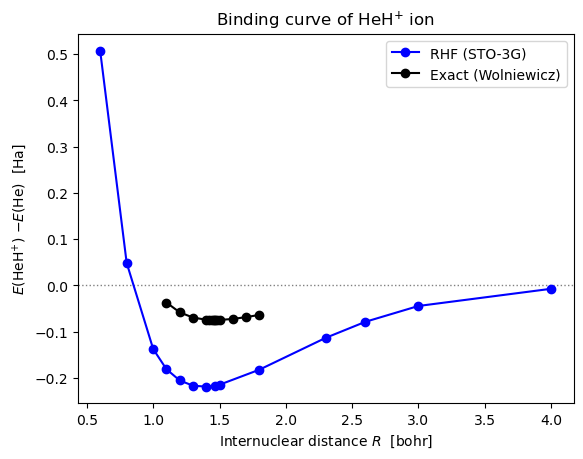

In [22]:
# Get reference energies
fname = 'HeH+_Wolniewicz.txt'
A = np.loadtxt(fname, skiprows=2, dtype=float)

# Plot the results
plt.axhline(0, ls=':', lw=1.0, color='gray')
plt.plot(R_list, E_bind_HeH, 'bo-', label='RHF (STO-3G)')
plt.plot(A[:,0], A[:,1] - E_He_exact, 'ko-', label='Exact (Wolniewicz)')
plt.xlabel('Internuclear distance $R$  [bohr]')
plt.ylabel(r'$E$(HeH$^{+}$) $- E$(He)  [Ha]')
plt.title(r'Binding curve of HeH$^{+}$ ion')
plt.legend()
plt.show()

As you can see, the equilibrium distance is predicted quite accurately. Remarkably, the dissociation limit is also qualitatively correct. However, the binding energy is overestimated by more than 100%. This is due to the deficiency of our minimal basis set (only 1 function per atom) as well as due to approximate nature of the HF method itself.

### Application to H$_2$ molecule

Now let's consider another 2 electron system - H$_2$ molecule, which is a textbook example in quantum chemistry. We will do the same as we did for HeH$^+$.

In [23]:
number_of_atoms = 2
atoms = ['H', 'H']

# Basis set size
B = 0
for atom in atoms:
    B += max_quantum_number[atom]

# Other book-keeping
# Number of electrons (important!)
N = 2

R_list = np.array([0.6, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.1, 2.2, 2.3, 2.6, 3.0, 3.5, 4.2])
E_list = []
E_H_sto3g = -0.466582

for R in R_list:
    atom_coordinates = geo_setup(R)
    E_nuc = get_nuclear_repulsion()
    Hcore, S, multi_electron_tensor, X = init_matrices()
    E_list.append(SCFcalc(Hcore, S, multi_electron_tensor, X) + E_nuc)
    
E_bind_RHF = np.array(E_list) - 2*E_H_sto3g


Internuclear distance is 0.600000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-2.334923e+00		-2.334923e+00		1.000000e+02
iter 2:		-2.334923e+00		1.332268e-15		1.000000e+02
iter 3:		-2.334923e+00		0.000000e+00		0.000000e+00

STO-3G Restricted Closed Shell HF algorithm converged in 3 iterations!
The orbital energies are -0.7926815845026143 and 1.3326459804332587 Hartrees

The orbital matrix is: 
[[-0.51077167  2.44749194]
 [-0.51077167 -2.44749194]]

The density/bond order matrix is: 
[[0.5217754 0.5217754]
 [0.5217754 0.5217754]]

################################################################################

Internuclear distance is 0.800000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-2.197308e+00		-2.197308e+00		1.000000e+02
iter 2:		-2.197308e+00		-4.440892e-16		1


Internuclear distance is 2.300000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-1.434426e+00		-1.434426e+00		1.000000e+02
iter 2:		-1.434426e+00		0.000000e+00		1.000000e+02
iter 3:		-1.434426e+00		0.000000e+00		0.000000e+00

STO-3G Restricted Closed Shell HF algorithm converged in 3 iterations!
The orbital energies are -0.42198481562979145 and 0.3358595400130829 Hartrees

The orbital matrix is: 
[[ 0.60225667  0.89694009]
 [ 0.60225667 -0.89694009]]

The density/bond order matrix is: 
[[0.72542619 0.72542619]
 [0.72542619 0.72542619]]

################################################################################

Internuclear distance is 2.600000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-1.333658e+00		-1.333658e+00		1.000000e+02
iter 2:		-1.333658e+00		0.000000e+0

Let's plot the results and compare the obtained RHF binding curve to the essentially exact calculations by Kolos and Wolniewicz.

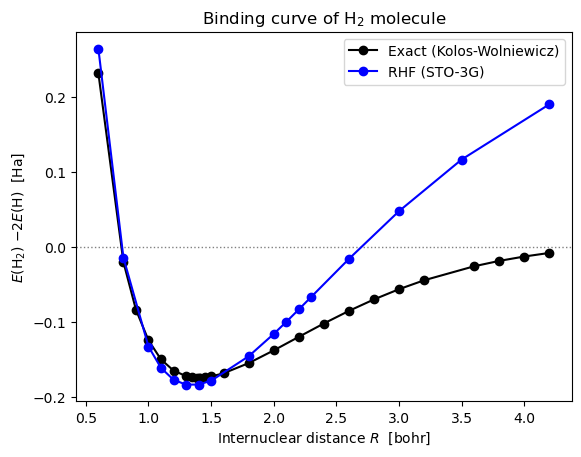

In [24]:
# Get reference energies
fname = 'H2_Kolos.txt'
A = np.loadtxt(fname, skiprows=2, dtype=float)

# Plot the results
#plt.close()
plt.axhline(0, ls=':', lw=1.0, color='gray')
plt.plot(A[:,0], A[:,1], 'ko-', label='Exact (Kolos-Wolniewicz)')
plt.plot(R_list, E_bind_RHF, 'bo-', label='RHF (STO-3G)')
plt.xlabel('Internuclear distance $R$  [bohr]')
plt.ylabel(r'$E$(H$_2$) $- 2E$(H)  [Ha]')
plt.title(r'Binding curve of H$_2$ molecule')
plt.legend()
plt.show()

In this case, equilibrium distance and binding energy both seem to be accurate (though further we will see that for energy it is a coincidence due to the small basis set). However, the dissociation limit is just horrible! Why is the behavior is so different between HeH$^+$ and H$_2$ cases? The answer is simple: HeH$^+$ dissociates into two closed-shell systems, He and H$^+$ (this is much more favorable energetically than He$^+$ and H), whereas H$_2$ dissociates into two H atoms, each carrying an unpaired electron. Therefore, the Restricted Hartree-Fock method, which is designed to treat closed-shell systems, can deal with HeH$^+$ dissociation but not with the H$_2$ case.

## Unrestricted Hartree-Fock algorithm

One way to overcome this difficulty is to relax the RHF condition that $\alpha$ and $\beta$ spin-orbitals should have the same spatial part. This new method is then called Unrestricted Hartree-Fock (UHF) and should be capable of treating open-shell systems. In the UHF method, we have two density matrices, which are expressed via the MO coefficient matrices as
\begin{equation}
    P_{\mu\nu}^{\alpha} = \sum_{a}^{N_{\alpha}} C_{\mu a}^{\alpha} (C_{\nu a}^{\alpha})^* \ , \ P_{\mu\nu}^{\beta} = \sum_{a}^{N_{\beta}} C_{\mu a}^{\beta} (C_{\nu a}^{\beta})^*
\end{equation}

The orbital matrices are obtained from the self-consistent solution of the Pople-Nesbet matrix equations:

\begin{equation}
    \mathbf{F}^{\alpha}\mathbf{C}^{\alpha} = \mathbf{S}\mathbf{C}^{\alpha}\mathbf{\varepsilon}^{\alpha} \ , \\
    \mathbf{F}^{\beta}\mathbf{C}^{\beta} = \mathbf{S}\mathbf{C}^{\beta}\mathbf{\varepsilon}^{\beta} \ .
\end{equation}

These equations are coupled via their Fock matrices:

\begin{equation}
    F^{\alpha}_{\mu\nu} = H^{core}_{\mu\nu} + \sum_{\lambda} \sum_{\sigma} P^{T}_{\lambda \sigma} (\mu \nu | \sigma \lambda) - P^{\alpha}_{\lambda \sigma} (\mu \lambda | \sigma \nu) \ , \\
    F^{\beta}_{\mu\nu} = H^{core}_{\mu\nu} + \sum_{\lambda} \sum_{\sigma} P^{T}_{\lambda \sigma} (\mu \nu | \sigma \lambda) - P^{\beta}_{\lambda \sigma} (\mu \lambda | \sigma \nu) \ ,
\end{equation}
where $P^{T}_{\lambda \sigma} = P^{\alpha}_{\lambda \sigma} + P^{\beta}_{\lambda \sigma}$ is the total density matrix.
Subsequently, the expression for the electronic energy is also modified:

\begin{equation}
    E_{elec} = \frac{1}{2} \sum_{\mu} \sum_{\nu} ( P^{T}_{\mu \nu} H^{core}_{\mu\nu} + P^{\alpha}_{\mu \nu} F^{\alpha}_{\mu\nu} + P^{\beta}_{\mu \nu} F^{\beta}_{\mu\nu} )  \ .
\end{equation}

In [25]:
def UHFcalc(Hcore, S, multi_electron_tensor, X, print_conv=True):
    # Main SCF algorithm for Unrestricted Hartree-Fock
    # Initial guess for density matrix (zero)
    P_alpha = np.zeros((B,B))
    P_beta = np.zeros((B,B))
    P_tot = P_alpha + P_beta
    P_alpha_prev = np.zeros((B,B))
    P_beta_prev = np.zeros((B,B))
    P_list = []
    
    if print_conv:
        print('\nInternuclear distance is {0:f} bohr'.format(R))
        print('Printing convergence info at every SCF step...\n')
        print('\t\t Total energy\t\t    Delta E\t\t  Delta rho')

    # Iterative process
    threshold = 100
    it = 0
    Eprev = 0
    miniter = 2
    while threshold > 1e-4:

        # Calculate Fock matrices for alpha and beta spin channels with guess
        G_alpha = np.zeros((B,B))
        G_beta = np.zeros((B,B))
        for i in range(B):
            for j in range(B):
                for x in range(B):
                    for y in range(B):
                        G_alpha[i,j] += P_tot[x,y] * multi_electron_tensor[i,j,y,x] - P_alpha[x,y] * multi_electron_tensor[i,x,y,j]
                        G_beta[i,j] += P_tot[x,y] * multi_electron_tensor[i,j,y,x] - P_beta[x,y] * multi_electron_tensor[i,x,y,j]
        
        Fock_alpha = Hcore + G_alpha
        Fock_beta = Hcore + G_beta
        
        # Electronic energy (pp 215)
        # For consistency, should be evaluated with the same density matrix, which was used to obtain Fock matrix
        E_elec = 0.5*(np.tensordot(P_tot.T, Hcore) + np.tensordot(P_alpha.T, Fock_alpha) + np.tensordot(P_beta.T, Fock_beta))

        # Calculate Fock matrix in orthogonalised base
        Fockprime_alpha = dot(X.T, dot(Fock_alpha, X))
        evalFockprime_alpha, Cprime_alpha = np.linalg.eig(Fockprime_alpha)
        Fockprime_beta = dot(X.T, dot(Fock_beta, X))
        evalFockprime_beta, Cprime_beta = np.linalg.eig(Fockprime_beta)

        # Correct ordering of eigenvalues and eigenvectors (starting from ground MO as first column of C, else we get the wrong P) 
        idx = evalFockprime_alpha.argsort()
        evalFockprime_alpha = evalFockprime_alpha[idx]
        Cprime_alpha = Cprime_alpha[:,idx]
        C_alpha = dot(X, Cprime_alpha)
        
        idx = evalFockprime_beta.argsort()
        evalFockprime_beta = evalFockprime_beta[idx]
        Cprime_beta = Cprime_beta[:,idx]
        
        # Breaking spatial symmetry for initial MO coefficients
        if it == 0:
            buf = Cprime_beta[:,0]
            Cprime_beta[:,0] = 1/np.sqrt(2) * (Cprime_beta[:,0] - Cprime_beta[:,1])
            Cprime_beta[:,1]= 1/np.sqrt(2) * (buf + Cprime_beta[:,1])
        
        C_beta = dot(X, Cprime_beta)
        
        # Form new density matrices P
        # In our case number of electrons N_alpha = N_beta = N/2
        for i in range(B):
            for j in range(B):
                for a in range(int(N/2)): 
                    P_alpha[i,j] = C_alpha[i,a]*C_alpha[j,a]
                    P_beta[i,j] = C_beta[i,a]*C_beta[j,a]

        P_tot = P_alpha + P_beta
        P_list.append(P_tot)

        t_alpha = densmat_diff(P_alpha_prev, P_alpha)
        t_beta = densmat_diff(P_beta_prev, P_beta)
        dE = E_elec - Eprev
        Eprev = E_elec
        P_alpha_prev = P_alpha
        P_beta_prev = P_beta
        
        if it > miniter:
            t_dens = max(t_alpha, t_beta)
            t_en = np.abs(dE/E_elec)
            threshold = max(t_dens, t_en)
        
        if print_conv:
            print('iter {0:d}:\t\t{1:e}\t\t{2:e}\t\t{3:e}'.format(it, E_elec, dE, threshold))
            #print('evalFockprime_alpha = {}'.format(evalFockprime_alpha))
            #print('evalFockprime_beta = {}'.format(evalFockprime_beta))
            #print (f'The Fock_alpha matrix is: \n{Fockprime_alpha}\n')
            #print (f'The Fock_beta matrix is: \n{Fockprime_beta}\n')
            #print (f'The alpha orbital matrix is: \n{Cprime_alpha}\n')
            #print (f'The beta orbital matrix is: \n{Cprime_beta}\n')
            #print (f'The alpha density/bond order matrix is: \n{P_alpha}\n')
            #print (f'The beta density/bond order matrix is: \n{P_beta}\n')
    
        it += 1
    
    # Final evaluation of the converged electronic energy
    E_elec = 0.5*(np.tensordot(P_tot.T, Hcore) + np.tensordot(P_alpha.T, Fock_alpha) + np.tensordot(P_beta.T, Fock_beta))
    
    # Calculate the number of electrons
    N_alpha = np.tensordot(P_alpha.T, S)
    N_beta = np.tensordot(P_beta.T, S)
    
    if print_conv:
        print('\nSTO-3G Unrestricted HF algorithm converged in {} iterations!'.format(it-1)) 
        print('The alpha-orbital energies are {} and {} Hartrees'.format(evalFockprime_alpha[0], evalFockprime_alpha[1]))
        print('The beta-orbital energies are {} and {} Hartrees\n'.format(evalFockprime_beta[0], evalFockprime_beta[1]))

        #print (f'The alpha orbital matrix is: \n{C_alpha}\n')
        #print (f'The beta orbital matrix is: \n{C_beta}\n')
        #print (f'The alpha density/bond order matrix is: \n{P_alpha}\n')
        #print (f'The beta density/bond order matrix is: \n{P_beta}\n')
        #print ('N_alpha = {}, N_beta = {}\n'.format(N_alpha, N_beta))
        print(80*'#')
    
    return E_elec, C_alpha, C_beta

### Unrestricted H$_2$ dissociation

Let's run the UHF calculation of H$_2$ dissociation (the two cells below). What do you see? Can you explain what happens looking at the UHF equations? What can you suggest to overcome the observed effect?

In [26]:
number_of_atoms = 2
atoms = ['H', 'H']

# Basis set size
B = 0
for atom in atoms:
    B += max_quantum_number[atom]

# Number of electrons (important!)
N = 2

R_list = np.array([0.6, 0.8, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2.0, 2.1, 2.2, 2.3, 2.6, 3.0, 3.5, 4.2])
E_list = []
E_H_sto3g = -0.466582

for R in R_list:
    atom_coordinates = geo_setup(R)
    E_nuc = get_nuclear_repulsion()
    Hcore, S, multi_electron_tensor, X = init_matrices()
    #print('Hcore = {}\nS = {}'.format(Hcore,S))
    E_elec, C_alpha, C_beta = UHFcalc(Hcore, S, multi_electron_tensor, X)
    E_list.append(E_elec + E_nuc)
    
E_bind_UHF = np.array(E_list) - 2*E_H_sto3g


Internuclear distance is 0.600000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-1.561142e+00		-1.561142e+00		1.000000e+02
iter 2:		-2.285854e+00		-7.247119e-01		1.000000e+02
iter 3:		-2.327858e+00		-4.200461e-02		1.804432e-02
iter 4:		-2.333683e+00		-5.824149e-03		2.495690e-03
iter 5:		-2.334701e+00		-1.018174e-03		4.361048e-04
iter 6:		-2.334883e+00		-1.823733e-04		7.810813e-05

STO-3G Unrestricted HF algorithm converged in 6 iterations!
The alpha-orbital energies are -0.7926786014522899 and 1.3326435236412781 Hartrees
The beta-orbital energies are -0.7926785149772767 and 1.3326434313796944 Hartrees

################################################################################

Internuclear distance is 0.800000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-1.547450e+


Internuclear distance is 2.300000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e+00		0.000000e+00		1.000000e+02
iter 1:		-1.245931e+00		-1.245931e+00		1.000000e+02
iter 2:		-1.427099e+00		-1.811672e-01		1.000000e+02
iter 3:		-1.435252e+00		-8.153006e-03		5.680542e-03
iter 4:		-1.435804e+00		-5.523202e-04		3.846766e-04
iter 5:		-1.436080e+00		-2.760833e-04		1.922478e-04
iter 6:		-1.436264e+00		-1.844557e-04		1.284274e-04
iter 7:		-1.436392e+00		-1.272968e-04		8.862263e-05

STO-3G Unrestricted HF algorithm converged in 7 iterations!
The alpha-orbital energies are -0.4507999127144056 and 0.3668022328859914 Hartrees
The beta-orbital energies are -0.4507994878900993 and 0.3668017728906252 Hartrees

################################################################################

Internuclear distance is 2.600000 bohr
Printing convergence info at every SCF step...

		 Total energy		    Delta E		  Delta rho
iter 0:		0.000000e

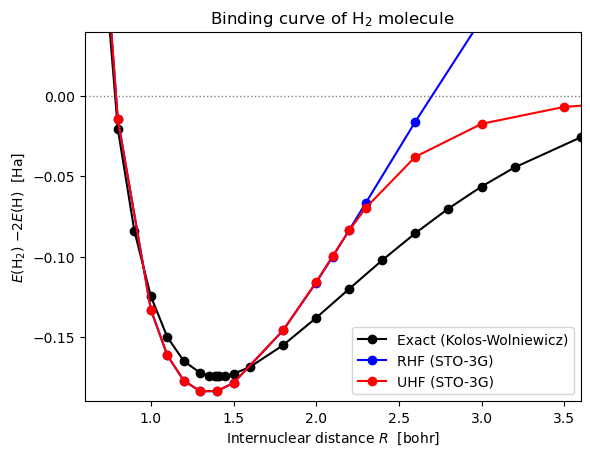

In [27]:
# Get reference energies
fname = 'H2_Kolos.txt'
A = np.loadtxt(fname, skiprows=2, dtype=float)

#plt.close()
plt.axhline(0, ls=':', lw=1.0, color='gray')
plt.plot(A[:,0], A[:,1], 'ko-', label='Exact (Kolos-Wolniewicz)')
plt.plot(R_list, E_bind_RHF, 'bo-', label='RHF (STO-3G)')
plt.plot(R_list, E_bind_UHF, 'ro-', label='UHF (STO-3G)')
plt.xlabel('Internuclear distance $R$  [bohr]')
plt.ylabel(r'$E$(H$_2$) $- 2E$(H)  [Ha]')
plt.title(r'Binding curve of H$_2$ molecule')
plt.xlim((0.6,3.6))
plt.ylim((-0.19,0.04))
plt.legend()
plt.show()

## Visualizing the wave functions

Finally, let's have a look at the obtained UHF wave functions along the dissociation curve. For this, we first need to write scripts recovering the explicit $\psi_{\alpha, \beta}(r)$ from the basis functions $\{ \phi_{\mu} \}$ and orbital coefficient matrix $\mathbf{C}$.

In [28]:
def gaussian(r, R, alpha):
    phi = (2*alpha/np.pi)**(3/4) * np.exp(-alpha*(r - R)**2)
    return phi

def wavefun(C_alpha, C_beta, r, R):
    # Dictionary of zeta values (pp159-160, 170) 
    zeta = 1.24
    # Gaussian 1s contraction coefficients (pp157)
    D = np.array([0.444635, 0.535328, 0.154329])
    # Gaussian 1s orbital exponents (pp153)
    alpha = np.array([0.109818, 0.405771, 2.22766])
    n = r.shape[0]
    phi_basis = np.zeros((n,2))
    
    for i in range(3):
        phi_basis[:,0] += D[i]*gaussian(r, 0, alpha[i]*zeta**2)
        phi_basis[:,1] += D[i]*gaussian(r, R, alpha[i]*zeta**2)
    
    # Wavefunction is defined up to the phase factor, so we can always choose to make it positive
    # Here we calculate only the occupied orbitals for alpha and beta spin
    psi_alpha_1 = np.abs(C_alpha[0,0]*phi_basis[:,0] + C_alpha[1,0]*phi_basis[:,1])
    psi_beta_1 = np.abs(C_beta[0,0]*phi_basis[:,0] + C_beta[1,0]*phi_basis[:,1])
    
    return psi_alpha_1, psi_beta_1

Now we can compute $\psi_{\alpha, \beta}(r)$ for three internuclear distances and then plot results.

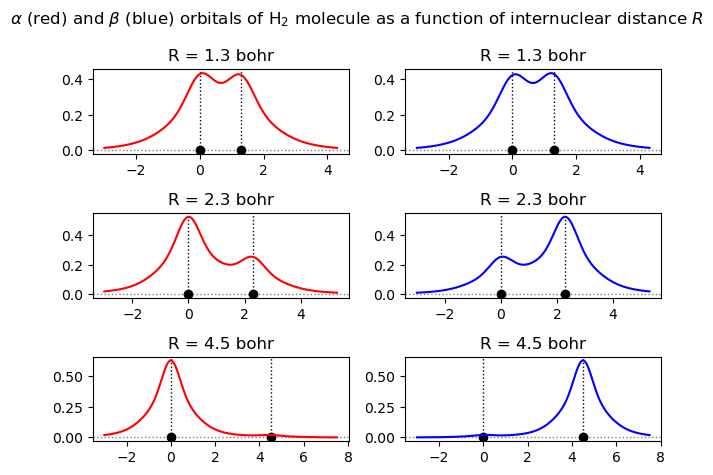

In [29]:
R_list = [1.3, 2.3, 4.5]
ngrid = 300
psi_alpha = np.zeros((ngrid,3))
psi_beta = np.zeros((ngrid,3))
for i in range(3):
    R = R_list[i]
    r = np.linspace(-3,R+3,ngrid)
    atom_coordinates = geo_setup(R)
    Hcore, S, multi_electron_tensor, X = init_matrices()
    E_elec, C_alpha, C_beta = UHFcalc(Hcore, S, multi_electron_tensor, X, print_conv=False)
    psi_alpha[:,i], psi_beta[:,i] = wavefun(C_alpha, C_beta, r, R)
    #print('C_alpha = \n{}\nC_beta = \n{}\n'.format(C_alpha, C_beta))

# Plotting the wave functions
#plt.close()
fig, ax = plt.subplots(3,2)
for i in range(3):
    R = R_list[i]
    r = np.linspace(-3,R+3,ngrid)
    ax[i,0].axhline(0, ls=':', lw=1.0, color='gray')
    ax[i,1].axhline(0, ls=':', lw=1.0, color='gray')
    ax[i,0].plot(0, 0, 'ko')
    ax[i,0].plot(R, 0, 'ko')
    ax[i,1].plot(0, 0, 'ko')
    ax[i,1].plot(R, 0, 'ko')
    ax[i,0].axvline(0, ls=':', lw=1.0, color='k')
    ax[i,0].axvline(R, ls=':', lw=1.0, color='k')
    ax[i,1].axvline(0, ls=':', lw=1.0, color='k')
    ax[i,1].axvline(R, ls=':', lw=1.0, color='k')
    ax[i,0].plot(r,psi_alpha[:,i], 'r-')
    ax[i,1].plot(r,psi_beta[:,i], 'b-')
    ax[i,0].set_title('R = {0:.1f} bohr'.format(R))
    ax[i,1].set_title('R = {0:.1f} bohr'.format(R))
fig.suptitle(r'$\alpha$ (red) and $\beta$ (blue) orbitals of H$_2$ molecule as a function of internuclear distance $R$')
fig.tight_layout()
plt.show()

We see that at distance $R = 1.3 \ {\rm bohr}$ (close to the equilibrium) the two wave functions are essentially identical and equally delocalized over the molecule. So, the UHF automatically reduces to the RHF. At critical distance $R = 2.3 \ {\rm bohr}$ (see the binding curve), covalent bond starts to break, which is indicated by a well-pronounced localization of wave functions near one of the nuclei. At the same time, the probability to find an electron at the second nuclei is still significant, and molecular orbital is still a valid concept. Finally, at distance of $R = 4.5 \ {\rm bohr}$, the wavefunctions are almost fully localized at the respective nuclei, amd molecular orbitals reduce to the non-interacting atomic orbitals. 

Thus, the UHF method delivers qualitatively satisfactory description of H$_2$ dissociation (although quantitatively it is quite far from the exact results). Actually, the good accuracy at near-equilibrium distances is due to the cancellation of errors of the method and the small basis set. The calculations with a larger 6-31G** basis set show significant underestimation of the H$_2$ binding energy at the Hartree-Fock level (see the figure from Szabo & Ostlund below). The UHF theory was also the first to explain why the ground-state of oxygen molecule with even number of electrons is actually a triplet.

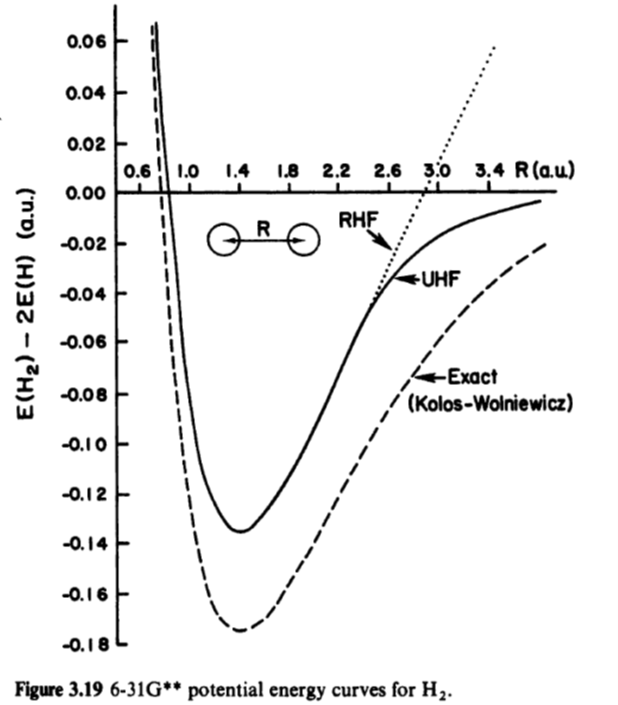

In [30]:
from IPython.display import Image
Image(filename='H2_6-31G_curve.png')

Unfortunately, UHF method has its own fundamental problems. For example, a single unrestricted Slater determinant is never the eigenfunction of spin operator, which leads to the so-called spin contamination problem. This means that the ground-state wave function of H$_2$ molecule is not a pure singlet, but contaminated by a singly excited triplet configuration.

## Conclusion
Overall, Hartree-Fock theory, which is often named as molecular orbital theory in chemistry courses, was a major success and one of the most important achievements of the electronic structure community. In many cases, HF calculations can provide qualitative and semi-quantitative explanations of molecular phenomena. However, very often HF theory fails even for seemingly simple systems. The textbook example is N$_2$ molecule, which has a strong static correlation and therefore cannot be described by Hartree-Fock or any other single-determinant method. Importantly, HF method lays foundation and serves as a starting point for many other quantum chemistry method, such as second-order Moeller-Plesset perturbation theory (MP2), configuration interaction (CI), coupled clusters (CC), etc.